# Spotify API
In this notebook, I play around with the Spotify Web API by
- retreiving various features about the music I listen to
- create new theme-based playlists based on these features

## Setup: Imports and OAuth

In [36]:
import pandas as pd
import pickle
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from mysecrets import SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET

In [2]:
auth_manager = SpotifyClientCredentials(client_secret = SPOTIPY_CLIENT_SECRET, client_id = SPOTIPY_CLIENT_ID)
sp = spotipy.Spotify(auth_manager=auth_manager)

## Implement Retrieval of Data

First of all, lets retreive all tracks from our playlist.

In [73]:
def retreive_playlist_items(playlist_uri):
    """
    Retreive all tracks from a playlist

    Parameters
    ----------
    playlist_uri : str

    Returns
    -------
    list
        List of playlist items being dictionaries with e.g. added_at, track
    """
    playlist = sp.playlist_items(playlist_uri)

    total = playlist["total"]
    items = playlist["items"]

    # Spotify API uses pagination
    for i in range(len(items), total, 100):
        items.extend( sp.playlist_items(playlist_uri, offset=i, fields=["items"])["items"] )

    return items

In [74]:
items = retreive_playlist_items("https://open.spotify.com/playlist/36unN1uVgmiNnnt5ErUb06?si=1f233f6262aa4b4f")

In [75]:
print(f"Playlist item has keys: {items[0].keys()}")
print(f"The contained track has: {items[9]['track'].keys()}")

Playlist item has keys: dict_keys(['added_at', 'added_by', 'is_local', 'primary_color', 'track', 'video_thumbnail'])
The contained track has: dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'episode', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track', 'track_number', 'type', 'uri'])


In the next step, clean up this data by removing unnecessary columns and splitting the items into several dataframes such that all columns are simple datatypes (string etc and not dict)

In [76]:
def clean_items(items):
    """
    Convert item list to dataframe and remove unnecessary columns

    Parameters
    ----------
    items : list
        List of playlist items being dictionaries

    Returns
    -------
    two pandas DataFrames
        First one with items as added_at, track uri
        Second one with tracks as uri, name, artist, duration_ms
    """
    # convert to dataframe and drop local items (not available on Spotify)
    df_items = pd.DataFrame(items, columns=["added_at", "is_local", "track"])
    df_items = df_items[df_items["is_local"] == False]
    df_items.drop(columns=["is_local"], inplace=True)

    # extract track information
    track_cols = [
        'artists', 'duration_ms', 'name', 'popularity', 'uri'
    ]
    df_tracks = pd.DataFrame(df_items.track.tolist(), columns=track_cols)
    df_items.track = df_tracks.uri
    df_items.rename(columns={"track": "track_uri"}, inplace=True)
    df_tracks.rename(columns={"uri": "track_uri"}, inplace=True)

    return df_items, df_tracks

In [77]:
df_items, df_tracks = clean_items(items)
df_tracks.head()

,artists,duration_ms,name,popularity,track_uri
0,[{'external_urls': {'spotify': 'https://open.s...,186815,Liberation,58,spotify:track:3I0PsB3pr6PPyesjPIXjA9
1,[{'external_urls': {'spotify': 'https://open.s...,216729,We Are Fucking Fucked,61,spotify:track:5IumuUJqNO7K5SvniuDrBz
2,[{'external_urls': {'spotify': 'https://open.s...,299060,Kill Or Be Killed,52,spotify:track:4E6pemZ3WutASrphiRINbd
3,[{'external_urls': {'spotify': 'https://open.s...,244866,Nameless Story,43,spotify:track:1XfLeMPPmMoCrXPvj3Pe2Z
4,[{'external_urls': {'spotify': 'https://open.s...,233933,リトルソルジャー,42,spotify:track:4ESR8uG70TFcWKqtePEJpo


In [9]:
# utility function for pagination
def chunks(items, size):
    for i in range(0, len(items), size):
        yield items[i:i + size]

In [80]:
def extract_artists(df_tracks):
    """
    Extract artists from tracks dataframe and retreive artist information

    Parameters
    ----------
    df_tracks : pandas DataFrame
        Dataframe with tracks
    
    Returns
    -------
    three pandas DataFrames
        First is df_tracks without artists
        Second one represents the relation between track and artist
        Third are the artists
    """
    # explode artists to separate rows
    df_madeby = df_tracks[["track_uri", "artists"]].explode("artists")
    df_madeby.artists = df_madeby.artists.apply(lambda x: x["uri"])
    df_madeby.rename(columns={"artists": "artist_uri"}, inplace=True)

    # retreive artist information, respect pagination
    artist_uris = df_madeby.artist_uri.unique()
    artists = []
    for chunk in chunks(artist_uris, 50):
        artists.extend(sp.artists(chunk)["artists"])
    
    # convert to dataframe
    df_artists = pd.DataFrame(artists, columns=["followers", "genres", "uri", "popularity", "name"])
    df_artists.followers = df_artists.followers.apply(lambda x: x["total"])
    df_artists.rename(columns={"uri": "artist_uri"}, inplace=True)

    df_tracks = df_tracks.drop(columns=["artists"])

    return df_tracks, df_madeby, df_artists

In [81]:
df_tracks, df_madeby, df_artists = extract_artists(df_tracks)

In [82]:
def extract_genres(df_artists):
    """
    Extract genres from artists dataframe

    Parameters
    ----------
    df_artists : pandas DataFrame
        Dataframe with artists

    Returns
    -------
    two pandas DataFrames
        First one being the artists without genres
        Second one being the relation between artist and genre
    """
    # explode genres to separate rows
    df_genres = df_artists[["artist_uri", "genres"]].explode("genres").rename(columns={"genres": "genre"})
    df_artists = df_artists.drop(columns=["genres"])

    return df_artists, df_genres


In [83]:
df_artists, df_genres = extract_genres(df_artists)

Finally, we use the web API to retreive high-level features about our tracks.

In [84]:
def retreive_track_features(df_tracks):
    features = list()
    for chunk in chunks(df_tracks.track_uri, 50):
        features.extend(sp.audio_features(chunk))
        
    df_features = pd.DataFrame(features)
    df_features.drop(columns=['type', 'id', 'track_href', 'analysis_url'], inplace=True)
    df_features.rename(columns={"uri": "track_uri"}, inplace=True)

    return df_features

In [85]:
df_features = retreive_track_features(df_tracks)

Lets put everything together into one function

In [89]:
def retreive_playlists(uris):
    playlist_names = [sp.playlist(uri)["name"] for uri in uris]

    if len(set(playlist_names)) != len(playlist_names):
        raise ValueError("Playlist names are not unique")

    df_playlists = pd.DataFrame()
    df_alltracks = pd.DataFrame()
    for uri, name in zip(uris, playlist_names):
        items = retreive_playlist_items(uri)
        df_items, df_tracks = clean_items(items)
        # add items to playlists including name as column
        df_items["playlist"] = name
        df_playlists = pd.concat([df_playlists, df_items])
        df_alltracks = pd.concat([df_alltracks, df_tracks])
    df_alltracks.drop_duplicates(inplace=True, subset=["track_uri"])
    
    df_alltracks, df_madeby, df_artists = extract_artists(df_alltracks)
    df_artists, df_genres = extract_genres(df_artists)
    df_features = retreive_track_features(df_alltracks)

    return {
        "playlists": df_playlists,
        "tracks": df_alltracks,
        "madeby": df_madeby,
        "artists": df_artists,
        "genres": df_genres,
        "features": df_features
    }

## Retrieve Playlists

In [87]:
uris = [
    "https://open.spotify.com/playlist/36unN1uVgmiNnnt5ErUb06?si=e00e18512e2c4978",
    "https://open.spotify.com/playlist/2xUcD1FSCzmBPjGgg2yfhw?si=48cc416375774d66",
    "https://open.spotify.com/playlist/2Byxogq9nVx3WoMnS4OIvK?si=44c8f67052084751",
    "https://open.spotify.com/playlist/7nkDhvgHMxbd8qnUyGay3b?si=50c077e607234b86"
]

In [90]:
if input("Retreive data from API? Can take a while, prefer pickle cache. [y/n] ") == "y":
    data = retreive_playlists(uris)
    with open("data.pkl", "wb") as f:
        pickle.dump(data, f)

In [91]:
with open("data.pkl", "rb") as f:
    data = pickle.load(f)

In [92]:
print(f"Retreived playlists: {data['playlists'].playlist.unique()}")
print(f"Number of tracks: {len(data['tracks'])}")
print(f"Available tables")
for k, v in data.items():
    print(f"\t{k}, columns: {list(v.columns)}")

Retreived playlists: ['favourites' 'Schulzeit' 'Party :D' 'Party']
Number of tracks: 1310
Available tables
	playlists, columns: ['added_at', 'track_uri', 'playlist']
	tracks, columns: ['duration_ms', 'name', 'popularity', 'track_uri']
	madeby, columns: ['track_uri', 'artist_uri']
	artists, columns: ['followers', 'artist_uri', 'popularity', 'name']
	genres, columns: ['artist_uri', 'genre']
	features, columns: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'track_uri', 'duration_ms', 'time_signature']


In [95]:
df_playlists = data["playlists"]
df_tracks = data["tracks"]
df_madeby = data["madeby"]
df_artists = data["artists"]
df_genres = data["genres"]
df_features = data["features"]

## Exploratory Analysis

### Which artists are most common in favourites?

In [100]:
artist_count = df_playlists[df_playlists["playlist"] == "favourites"] \
    .merge(df_madeby, on="track_uri") \
    .merge(df_artists, on="artist_uri") \
    .groupby("name") \
    .count() \
    .sort_values("artist_uri", ascending=False) \
    .artist_uri \
    .reset_index() \
    .rename(columns={"artist_uri": "count"})
artist_count.head(10)

,name,count
0,Fall Out Boy,23
1,Muse,20
2,Alligatoah,12
3,My Chemical Romance,10
4,The Wombats,9
5,Queen,8
6,Foo Fighters,7
7,Eminem,7
8,All Time Low,6
9,Panic! At The Disco,6


### Most popular artists with more than two songs in favourites

In [102]:
popular_artists = df_playlists[df_playlists["playlist"] == "favourites"] \
    .merge(df_madeby, on="track_uri") \
    .merge(df_artists, on="artist_uri") \
    .groupby(["name", "popularity"]) \
    .count() \
    .query("artist_uri > 2") \
    .sort_values("popularity", ascending=False) \
    .artist_uri \
    .reset_index() \
    .rename(columns={"artist_uri": "count"})
popular_artists.head(10)

,name,popularity,count
0,Eminem,90,7
1,Arctic Monkeys,87,3
2,Imagine Dragons,87,5
3,Maroon 5,84,3
4,Queen,84,8
5,Elton John,84,3
6,Metallica,81,3
7,Lil Nas X,81,3
8,AC/DC,80,4
9,Guns N' Roses,79,5


### Cluster favourites playlist

In [103]:
df_favs = df_playlists[df_playlists["playlist"] == "favourites"] \
    .merge(df_features, on="track_uri")

In [132]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

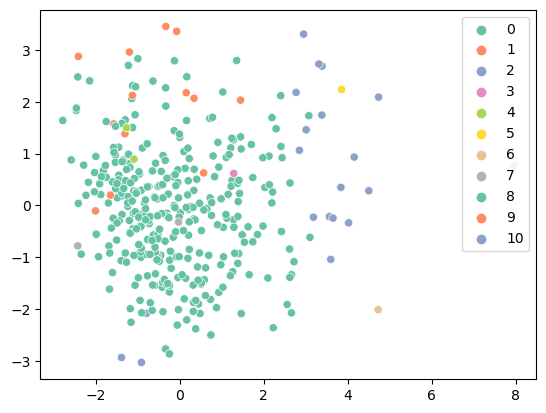

In [127]:
# perform clustering through mean shift
scaler = StandardScaler()
X = scaler.fit_transform(df_favs[["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]])
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
# plot dimensionally reduced
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2")
plt.show()

In [136]:
np.bincount(labels)

array([322,   8,   3,   1,   2,   1,   2,   3,   1,   5,  16], dtype=int64)

In [142]:
# for each ms cluster, print track closest to center
cluster_centre = []
for i in range(len(np.bincount(labels))):
    c = df_favs.iloc[np.argmin(np.linalg.norm(X[labels == i] - ms.cluster_centers_[i], axis=1))]["track_uri"]
    cluster_centre.append(c)
# print the names of these tracks using df_tracks
df_tracks[df_tracks["track_uri"].isin(cluster_centre)]

,duration_ms,name,popularity,track_uri
0,186815,Liberation,58,spotify:track:3I0PsB3pr6PPyesjPIXjA9
1,216729,We Are Fucking Fucked,61,spotify:track:5IumuUJqNO7K5SvniuDrBz
2,299060,Kill Or Be Killed,52,spotify:track:4E6pemZ3WutASrphiRINbd
7,271826,On The Mend,42,spotify:track:39kHMfF3dBMZMbOtoit1XF
15,404106,Stan,84,spotify:track:3UmaczJpikHgJFyBTAJVoz
204,252933,Now I'm Here - Remastered 2011,49,spotify:track:5v1osKVFv3rXWb1VJDO9pW


## Create theme-based playlists

In [155]:
def pasteable_playlist(uris):
    uris = [uri.replace("spotify:track:", "https://open.spotify.com/track/") for uri in uris]
    res = "\n".join(uris)
    return res

### Dancing

In [ ]:
df_dance = df_playlists[df_playlists["playlist"] != "Schulzeit"] \
    .merge(df_features, on="track_uri") \
    .sort_values("danceability", ascending=False)
print(pasteable_playlist(df_dance.track_uri.unique()[:50]))

### Upbeat

energy > 0.7 and valence > 0.5 and instrumentalness < 0.2 and danceability > 0.6

In [143]:
df_upbeat = df_playlists[df_playlists["playlist"] == "favourites"] \
    .merge(df_features, on="track_uri") \
    .query("energy > 0.7 and valence > 0.5 and instrumentalness < 0.2 and danceability > 0.6") \
    .sort_values(lambda x: x["energy"] + x["valence"] + x["danceability"], ascending=False)
print(pasteable_playlist(df_upbeat.head(50)["track_uri"].values))